<a href="https://colab.research.google.com/github/hiroshihv89/PROYECTO_TRIMAX_ML/blob/main/modelo_trimax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTAMOS LIBRERIAS**

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# **Simulación de datos de órdenes y generación de variable de retraso**


In [ ]:

# Definir número de órdenes simuladas
n_orders = 5000  # Cambiado a 5000

# Definir productos simulados
productos = ['TRIMAX ECO Plus 16mm', 'ESSILOR Varilux PHYSIO', 'ESSILOR EYEZEN Kids', 'PENTAX Allfocus']

# Generar columnas base
df_sim = pd.DataFrame({
    'TIPO': np.random.choice(['FABRICACION', 'BISELADO', 'FABRICACION Y BISELADO'], n_orders),
    'SIMTIPO': np.random.choice(['F','B','FB'], n_orders),
    'PRODUCTO': np.random.choice(productos, n_orders)
})

# Función para generar rangos de fechas aleatorias
def random_date_range(start, max_hours=48):
    start_date = start + timedelta(hours=np.random.randint(0, max_hours))
    end_date = start_date + timedelta(hours=np.random.randint(1, 5))
    return start_date, end_date

# Generar fechas simuladas para etapas
stages = ['SOLICITADO','INSPECCION','TALLADO','CONTROL_CALIDAD','ESPERA_NOX',
          'RECEPCION_PEDIDO','LAVADORA_NOX','SECADO_NOX','ESPERA_CAMARA_NOX',
          'CAMARA_NOX','FIN_NOX']

start_base = datetime(2025,1,2,7,0,0)

for stage in stages:
    start_dates = []
    end_dates = []
    for _ in range(n_orders):
        s,e = random_date_range(start_base)
        start_dates.append(s)
        end_dates.append(e)
    df_sim[f'{stage}_DESDE'] = start_dates
    df_sim[f'{stage}_HASTA'] = end_dates

# Crear columna de retraso: 1 si FIN_NOX_HASTA > cierto umbral
threshold_hours = 24
df_sim['RETRASO'] = ((df_sim['FIN_NOX_HASTA'] - df_sim['SOLICITADO_DESDE']).dt.total_seconds()/3600 > threshold_hours).astype(int)

# Mostrar las primeras filas
df_sim.head()


,TIPO,SIMTIPO,PRODUCTO,SOLICITADO_DESDE,SOLICITADO_HASTA,INSPECCION_DESDE,INSPECCION_HASTA,TALLADO_DESDE,TALLADO_HASTA,CONTROL_CALIDAD_DESDE,...,LAVADORA_NOX_HASTA,SECADO_NOX_DESDE,SECADO_NOX_HASTA,ESPERA_CAMARA_NOX_DESDE,ESPERA_CAMARA_NOX_HASTA,CAMARA_NOX_DESDE,CAMARA_NOX_HASTA,FIN_NOX_DESDE,FIN_NOX_HASTA,RETRASO
0,BISELADO,B,ESSILOR Varilux PHYSIO,2025-01-03 13:00:00,2025-01-03 17:00:00,2025-01-04 01:00:00,2025-01-04 05:00:00,2025-01-02 21:00:00,2025-01-02 23:00:00,2025-01-02 20:00:00,...,2025-01-03 12:00:00,2025-01-03 16:00:00,2025-01-03 19:00:00,2025-01-03 17:00:00,2025-01-03 18:00:00,2025-01-03 01:00:00,2025-01-03 05:00:00,2025-01-04 00:00:00,2025-01-04 01:00:00,0
1,FABRICACION,B,PENTAX Allfocus,2025-01-02 19:00:00,2025-01-02 22:00:00,2025-01-03 17:00:00,2025-01-03 18:00:00,2025-01-02 14:00:00,2025-01-02 16:00:00,2025-01-02 12:00:00,...,2025-01-02 23:00:00,2025-01-03 00:00:00,2025-01-03 03:00:00,2025-01-04 02:00:00,2025-01-04 06:00:00,2025-01-03 16:00:00,2025-01-03 17:00:00,2025-01-02 14:00:00,2025-01-02 16:00:00,0
2,FABRICACION,F,ESSILOR EYEZEN Kids,2025-01-03 05:00:00,2025-01-03 06:00:00,2025-01-02 22:00:00,2025-01-03 00:00:00,2025-01-04 00:00:00,2025-01-04 01:00:00,2025-01-02 21:00:00,...,2025-01-02 17:00:00,2025-01-04 04:00:00,2025-01-04 05:00:00,2025-01-03 16:00:00,2025-01-03 20:00:00,2025-01-03 17:00:00,2025-01-03 19:00:00,2025-01-04 01:00:00,2025-01-04 05:00:00,0
3,BISELADO,FB,TRIMAX ECO Plus 16mm,2025-01-03 08:00:00,2025-01-03 10:00:00,2025-01-03 00:00:00,2025-01-03 01:00:00,2025-01-03 16:00:00,2025-01-03 19:00:00,2025-01-03 01:00:00,...,2025-01-04 04:00:00,2025-01-03 10:00:00,2025-01-03 14:00:00,2025-01-04 00:00:00,2025-01-04 01:00:00,2025-01-03 12:00:00,2025-01-03 13:00:00,2025-01-03 18:00:00,2025-01-03 21:00:00,0
4,BISELADO,FB,PENTAX Allfocus,2025-01-02 22:00:00,2025-01-03 01:00:00,2025-01-02 22:00:00,2025-01-03 01:00:00,2025-01-02 22:00:00,2025-01-03 02:00:00,2025-01-04 03:00:00,...,2025-01-04 04:00:00,2025-01-02 17:00:00,2025-01-02 20:00:00,2025-01-04 04:00:00,2025-01-04 07:00:00,2025-01-03 12:00:00,2025-01-03 13:00:00,2025-01-03 08:00:00,2025-01-03 09:00:00,0


# **Análisis exploratorio de la distribución de retrasos y cálculo de duraciones de etapas**

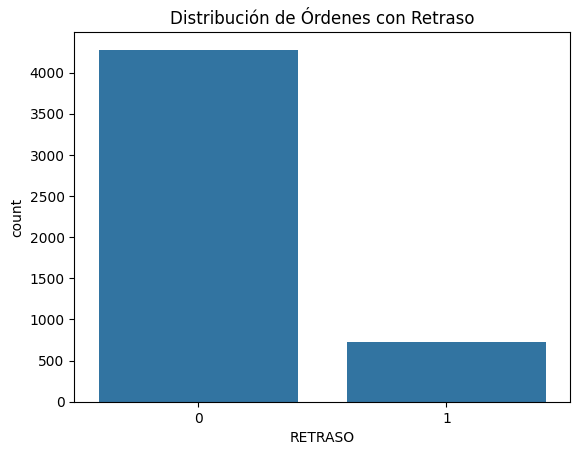

,TIPO,SIMTIPO,PRODUCTO,SOLICITADO_DESDE,SOLICITADO_HASTA,INSPECCION_DESDE,INSPECCION_HASTA,TALLADO_DESDE,TALLADO_HASTA,CONTROL_CALIDAD_DESDE,...,INSPECCION_DURACION,TALLADO_DURACION,CONTROL_CALIDAD_DURACION,ESPERA_NOX_DURACION,RECEPCION_PEDIDO_DURACION,LAVADORA_NOX_DURACION,SECADO_NOX_DURACION,ESPERA_CAMARA_NOX_DURACION,CAMARA_NOX_DURACION,FIN_NOX_DURACION
0,BISELADO,B,ESSILOR Varilux PHYSIO,2025-01-03 13:00:00,2025-01-03 17:00:00,2025-01-04 01:00:00,2025-01-04 05:00:00,2025-01-02 21:00:00,2025-01-02 23:00:00,2025-01-02 20:00:00,...,4.0,2.0,4.0,4.0,1.0,3.0,3.0,1.0,4.0,1.0
1,FABRICACION,B,PENTAX Allfocus,2025-01-02 19:00:00,2025-01-02 22:00:00,2025-01-03 17:00:00,2025-01-03 18:00:00,2025-01-02 14:00:00,2025-01-02 16:00:00,2025-01-02 12:00:00,...,1.0,2.0,4.0,2.0,2.0,2.0,3.0,4.0,1.0,2.0
2,FABRICACION,F,ESSILOR EYEZEN Kids,2025-01-03 05:00:00,2025-01-03 06:00:00,2025-01-02 22:00:00,2025-01-03 00:00:00,2025-01-04 00:00:00,2025-01-04 01:00:00,2025-01-02 21:00:00,...,2.0,1.0,4.0,1.0,2.0,4.0,1.0,4.0,2.0,4.0
3,BISELADO,FB,TRIMAX ECO Plus 16mm,2025-01-03 08:00:00,2025-01-03 10:00:00,2025-01-03 00:00:00,2025-01-03 01:00:00,2025-01-03 16:00:00,2025-01-03 19:00:00,2025-01-03 01:00:00,...,1.0,3.0,3.0,3.0,1.0,2.0,4.0,1.0,1.0,3.0
4,BISELADO,FB,PENTAX Allfocus,2025-01-02 22:00:00,2025-01-03 01:00:00,2025-01-02 22:00:00,2025-01-03 01:00:00,2025-01-02 22:00:00,2025-01-03 02:00:00,2025-01-04 03:00:00,...,3.0,4.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0,1.0


In [ ]:
# Distribución de retrasos
sns.countplot(x='RETRASO', data=df_sim)
plt.title('Distribución de Órdenes con Retraso')
plt.show()

# Duración promedio por etapa
for stage in stages:
    df_sim[f'{stage}_DURACION'] = (df_sim[f'{stage}_HASTA'] - df_sim[f'{stage}_DESDE']).dt.total_seconds()/3600

# Ver primeras filas con duraciones
df_sim.head()


# **“Selección de features, codificación de variables categóricas y división de datos para entrenamiento y prueba”**



In [ ]:
# Seleccionamos columnas numéricas como features
features = [f'{stage}_DURACION' for stage in stages] + ['SIMTIPO', 'TIPO', 'PRODUCTO']

# Convertir categóricas a números
df_ml = df_sim.copy()
for col in ['SIMTIPO', 'TIPO', 'PRODUCTO']:
    df_ml[col] = df_ml[col].astype('category').cat.codes

X = df_ml[features]
y = df_ml['RETRASO']

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# **Entrenamiento de modelo Random Forest y evaluación de desempeño**

Accuracy: 0.865

Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.93       865
           1       0.00      0.00      0.00       135

    accuracy                           0.86      1000
   macro avg       0.43      0.50      0.46      1000
weighted avg       0.75      0.86      0.80      1000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


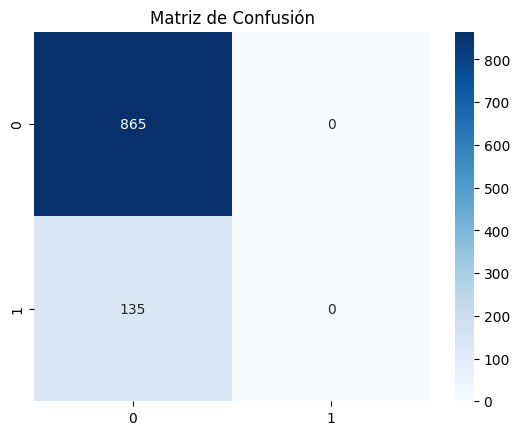

In [ ]:
# Definir número de órdenes simuladas
n_orders = 5000

# Definir productos simulados
productos = ['TRIMAX ECO Plus 16mm', 'ESSILOR Varilux PHYSIO', 'ESSILOR EYEZEN Kids', 'PENTAX Allfocus']

# Generar columnas base
df_sim = pd.DataFrame({
    'TIPO': np.random.choice(['FABRICACION', 'BISELADO', 'FABRICACION Y BISELADO'], n_orders),
    'SIMTIPO': np.random.choice(['F','B','FB'], n_orders),
    'PRODUCTO': np.random.choice(productos, n_orders)
})

# Función para generar rangos de fechas aleatorias
def random_date_range(start, max_hours=48):
    start_date = start + timedelta(hours=np.random.randint(0, max_hours))
    end_date = start_date + timedelta(hours=np.random.randint(1, 5))
    return start_date, end_date

# Generar fechas simuladas para etapas
stages = ['SOLICITADO','INSPECCION','TALLADO','CONTROL_CALIDAD','ESPERA_NOX',
          'RECEPCION_PEDIDO','LAVADORA_NOX','SECADO_NOX','ESPERA_CAMARA_NOX',
          'CAMARA_NOX','FIN_NOX']

start_base = datetime(2025,1,2,7,0,0)

for stage in stages:
    start_dates = []
    end_dates = []
    for _ in range(n_orders):
        s,e = random_date_range(start_base)
        start_dates.append(s)
        end_dates.append(e)
    df_sim[f'{stage}_DESDE'] = start_dates
    df_sim[f'{stage}_HASTA'] = end_dates

# Crear columna de retraso: 1 si FIN_NOX_HASTA > cierto umbral
threshold_hours = 24
df_sim['RETRASO'] = ((df_sim['FIN_NOX_HASTA'] - df_sim['SOLICITADO_DESDE']).dt.total_seconds()/3600 > threshold_hours).astype(int)

# --- Calculate stage durations (from cell iXcUgoqu-1EB) ---
for stage in stages:
    df_sim[f'{stage}_DURACION'] = (df_sim[f'{stage}_HASTA'] - df_sim[f'{stage}_DESDE']).dt.total_seconds()/3600

# --- Feature selection, categorical encoding, and data split (from cell eSxCK1GK--9m) ---
# Seleccionamos columnas numéricas como features
features = [f'{stage}_DURACION' for stage in stages] + ['SIMTIPO', 'TIPO', 'PRODUCTO']

# Convertir categóricas a números
df_ml = df_sim.copy()
for col in ['SIMTIPO', 'TIPO', 'PRODUCTO']:
    df_ml[col] = df_ml[col].astype('category').cat.codes

X = df_ml[features]
y = df_ml['RETRASO']

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Random Forest Model Training and Evaluation ---
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.show()

# **Análisis de importancia de variables del modelo Random Forest para identificar factores críticos de retraso**



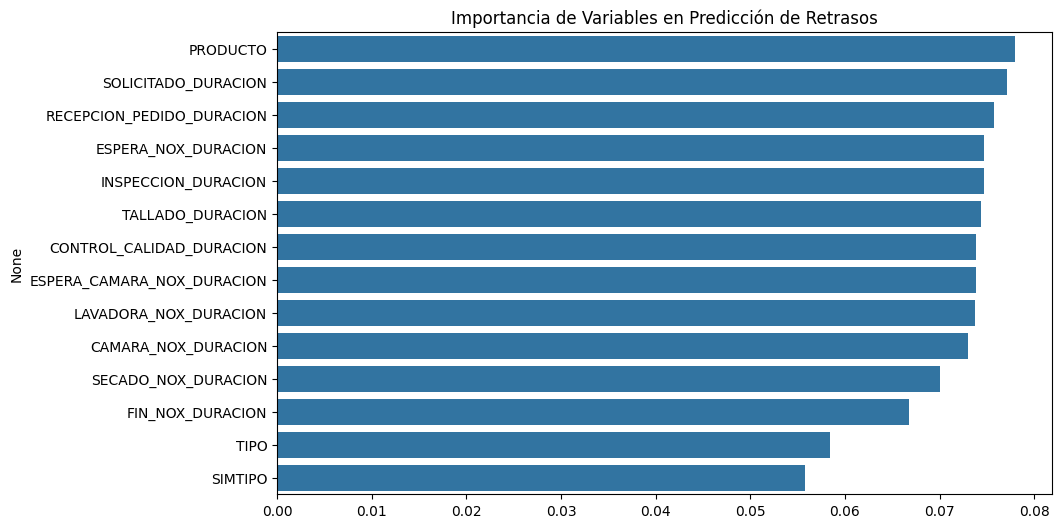

In [ ]:
importances = model.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Importancia de Variables en Predicción de Retrasos")
plt.show()


In [ ]:
import joblib

joblib.dump(model, "modelo_random_forest.pkl")


['modelo_random_forest.pkl']

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import pandas as pd

# ---------------------
# CARGAR MODELO
# ---------------------
model = joblib.load("modelo_random_forest.pkl")

# ---------------------
# DEFINIR API
# ---------------------
app = FastAPI(title="API de Predicción TRIMAX")

# ---------------------
# MODELO DE ENTRADA
# ---------------------
class Orden(BaseModel):
    TIPO: int
    SIMTIPO: int
    PRODUCTO: int
    SOLICITADO_DURACION: float
    INSPECCION_DURACION: float
    TALLADO_DURACION: float
    CONTROL_CALIDAD_DURACION: float
    ESPERA_NOX_DURACION: float
    RECEPCION_PEDIDO_DURACION: float
    LAVADORA_NOX_DURACION: float
    SECADO_NOX_DURACION: float
    ESPERA_CAMARA_NOX_DURACION: float
    CAMARA_NOX_DURACION: float
    FIN_NOX_DURACION: float

# ---------------------
# ENDPOINT
# ---------------------
@app.post("/predecir")
def predecir_retraso(orden: Orden):

    df = pd.DataFrame([orden.dict()])

    pred = model.predict(df)[0]
    prob = model.predict_proba(df)[0][1]

    return {
        "retraso": int(pred),
        "probabilidad": float(prob)
    }


In [ ]:
!pip install fastapi uvicorn nest-asyncio pyngrok joblib pandas scikit-learn



In [ ]:
from pyngrok import ngrok
ngrok.set_auth_token("2v1Swx1GAlw39Lb7lcCaB8XWP55_7qnq6vLjmzzdwxJM4vtz3")
public_url = ngrok.connect(8000)
public_url


<NgrokTunnel: "https://285182cb9869.ngrok-free.app" -> "http://localhost:8000">

In [ ]:
!pip install fastapi uvicorn nest_asyncio pyngrok

import nest_asyncio
import uvicorn
from fastapi import FastAPI
from threading import Thread

nest_asyncio.apply()  # permite que uvicorn corra dentro de Colab

app = FastAPI()

@app.get("/")
def root():
    return {"status": "API OK"}

@app.post("/predecir")
def predecir(data: dict):
    return {"resultado": "OK", "recibido": data}

# Función para ejecutar uvicorn en hilo
def run():
    uvicorn.run(app, host="0.0.0.0", port=8000)

# Crear y arrancar el hilo
thread = Thread(target=run, daemon=True)
thread.start()

print("API corriendo en http://localhost:8000")


API corriendo en http://localhost:8000


In [ ]:
from pyngrok import ngrok

public_url = ngrok.connect(8000)
print("URL pública:", public_url)


URL pública: NgrokTunnel: "https://0420ef5c0b4a.ngrok-free.app" -> "http://localhost:8000"
